In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_S5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Mon Mar 22 09:08:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
| 94%   81C    P0    97W / 250W |      0MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 71%   

In [10]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = '/data/save/model_S5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json    save_137981  save_190000  save_242209  save_306501  save_375000
save_100000  save_138253  save_195000  save_245000  save_310000  save_380000
save_100189  save_140000  save_196835  save_247546  save_315000  save_385000
save_100481  save_145000  save_199144  save_248082  save_320000  save_387320
save_100728  save_146358  save_200000  save_250000  save_324281  save_400000
save_104221  save_147866  save_201253  save_255000  save_325000  save_710471
save_105000  save_150000  save_205000  save_258351  save_330000  save_710898
save_110000  save_151422  save_210000  save_258531  save_335000  save_715000
save_115000  save_155000  save_215000  save_260000  save_340000  save_719469
save_120000  save_160000  save_219392  save_265000  save_344332  save_75000
save_123593  save_165000  save_220000  save_270000  save_345000  save_80000
save_123671  save_170000  save_225000  save_275000  save_350000  save_85000
save_123692  save_170017  save_228147  save_280000  save_353107  save_90000
sav

In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 719469

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 283.0MiB
TTS size 195.3MiB
MelEncoder size 65.3MiB
MelDecoder size 119.0MiB
loaded : 719469
719469
done


In [6]:
trainset = LJDataset(tts_hparams, split='train')
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.0630563497543335


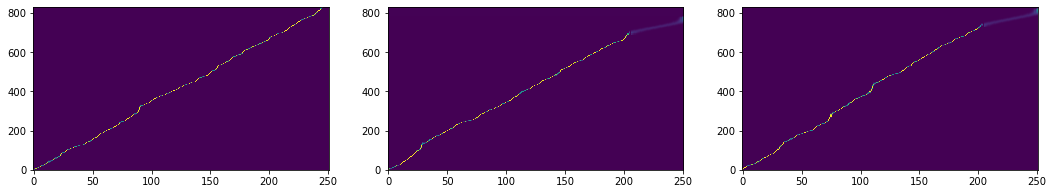

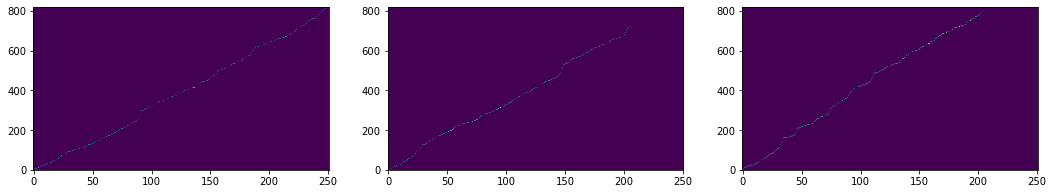

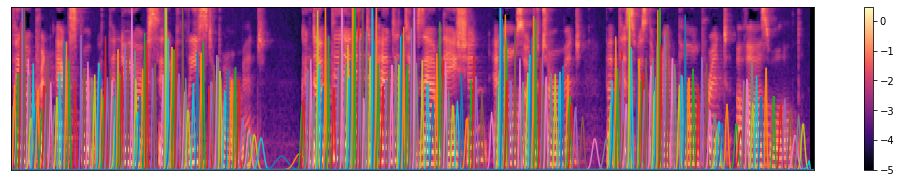

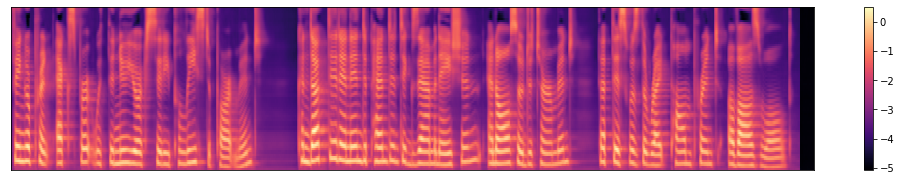

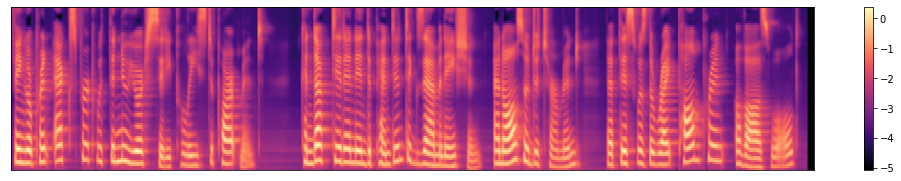

tensor(0.1660, device='cuda:0')
step : 733001 stt : 0.0018 tts : 0.1386 recon : 0.0224 kl : 0.0058 beta : 1.0000
tensor(0.1597, device='cuda:0')
step : 733002 stt : 0.0008 tts : 0.1330 recon : 0.0198 kl : 0.0051 beta : 1.0000
tensor(0.1398, device='cuda:0')
step : 733003 stt : 0.0007 tts : 0.1469 recon : 0.0230 kl : 0.0058 beta : 1.0000
tensor(0.1330, device='cuda:0')
step : 733004 stt : 0.0003 tts : 0.1326 recon : 0.0225 kl : 0.0057 beta : 1.0000
tensor(0.1744, device='cuda:0')
step : 733005 stt : 0.0018 tts : 0.1487 recon : 0.0238 kl : 0.0060 beta : 1.0000
tensor(0.1545, device='cuda:0')
step : 733006 stt : 0.0011 tts : 0.1415 recon : 0.0238 kl : 0.0062 beta : 1.0000
tensor(0.1453, device='cuda:0')
step : 733007 stt : 0.0015 tts : 0.1548 recon : 0.0235 kl : 0.0062 beta : 1.0000
tensor(0.1781, device='cuda:0')
step : 733008 stt : 0.0017 tts : 0.1431 recon : 0.0239 kl : 0.0062 beta : 1.0000
tensor(0.1266, device='cuda:0')
step : 733009 stt : 0.0005 tts : 0.1368 recon : 0.0233 kl : 0.00

tensor(0.1408, device='cuda:0')
step : 733074 stt : 0.0011 tts : 0.1450 recon : 0.0247 kl : 0.0063 beta : 1.0000
tensor(0.1190, device='cuda:0')
step : 733075 stt : 0.0006 tts : 0.1307 recon : 0.0235 kl : 0.0061 beta : 1.0000
tensor(0.1133, device='cuda:0')
step : 733076 stt : 0.0008 tts : 0.1292 recon : 0.0231 kl : 0.0060 beta : 1.0000
tensor(0.1531, device='cuda:0')
step : 733077 stt : 0.0006 tts : 0.1358 recon : 0.0207 kl : 0.0055 beta : 1.0000
tensor(0.1065, device='cuda:0')
step : 733078 stt : 0.0007 tts : 0.1297 recon : 0.0235 kl : 0.0061 beta : 1.0000
tensor(0.1387, device='cuda:0')
step : 733079 stt : 0.0014 tts : 0.1342 recon : 0.0219 kl : 0.0057 beta : 1.0000
tensor(0.1268, device='cuda:0')
step : 733080 stt : 0.0008 tts : 0.1398 recon : 0.0259 kl : 0.0064 beta : 1.0000
tensor(0.1360, device='cuda:0')
step : 733081 stt : 0.0004 tts : 0.1343 recon : 0.0208 kl : 0.0055 beta : 1.0000
tensor(0.1566, device='cuda:0')
step : 733082 stt : 0.0005 tts : 0.1393 recon : 0.0228 kl : 0.00

tensor(0.1032, device='cuda:0')
step : 733147 stt : 0.0006 tts : 0.1402 recon : 0.0235 kl : 0.0060 beta : 1.0000
tensor(0.1334, device='cuda:0')
step : 733148 stt : 0.0003 tts : 0.1271 recon : 0.0225 kl : 0.0057 beta : 1.0000
tensor(0.1012, device='cuda:0')
step : 733149 stt : 0.0003 tts : 0.1357 recon : 0.0217 kl : 0.0056 beta : 1.0000
tensor(0.0979, device='cuda:0')
step : 733150 stt : 0.0007 tts : 0.1360 recon : 0.0233 kl : 0.0059 beta : 1.0000
tensor(0.1265, device='cuda:0')
step : 733151 stt : 0.0006 tts : 0.1452 recon : 0.0264 kl : 0.0065 beta : 1.0000
tensor(0.1471, device='cuda:0')
step : 733152 stt : 0.0013 tts : 0.1294 recon : 0.0231 kl : 0.0059 beta : 1.0000
tensor(0.0984, device='cuda:0')
step : 733153 stt : 0.0003 tts : 0.1320 recon : 0.0223 kl : 0.0057 beta : 1.0000
tensor(0.1208, device='cuda:0')
step : 733154 stt : 0.0007 tts : 0.1332 recon : 0.0217 kl : 0.0056 beta : 1.0000
tensor(0.1348, device='cuda:0')
step : 733155 stt : 0.0008 tts : 0.1444 recon : 0.0239 kl : 0.00

tensor(0.1218, device='cuda:0')
step : 733220 stt : 0.0003 tts : 0.1349 recon : 0.0249 kl : 0.0064 beta : 1.0000
tensor(0.0858, device='cuda:0')
step : 733221 stt : 0.0003 tts : 0.1282 recon : 0.0223 kl : 0.0058 beta : 1.0000
tensor(0.1120, device='cuda:0')
step : 733222 stt : 0.0015 tts : 0.1330 recon : 0.0217 kl : 0.0057 beta : 1.0000
tensor(0.1486, device='cuda:0')
step : 733223 stt : 0.0004 tts : 0.1377 recon : 0.0221 kl : 0.0058 beta : 1.0000
tensor(0.1403, device='cuda:0')
step : 733224 stt : 0.0005 tts : 0.1476 recon : 0.0237 kl : 0.0062 beta : 1.0000
tensor(0.1195, device='cuda:0')
step : 733225 stt : 0.0004 tts : 0.1315 recon : 0.0212 kl : 0.0055 beta : 1.0000
tensor(0.0906, device='cuda:0')
step : 733226 stt : 0.0004 tts : 0.1305 recon : 0.0226 kl : 0.0059 beta : 1.0000
tensor(0.1283, device='cuda:0')
step : 733227 stt : 0.0008 tts : 0.1377 recon : 0.0226 kl : 0.0058 beta : 1.0000
tensor(0.1320, device='cuda:0')
step : 733228 stt : 0.0005 tts : 0.1345 recon : 0.0214 kl : 0.00

tensor(0.0920, device='cuda:0')
step : 733293 stt : 0.0003 tts : 0.1297 recon : 0.0222 kl : 0.0058 beta : 1.0000
tensor(0.0930, device='cuda:0')
step : 733294 stt : 0.0005 tts : 0.1336 recon : 0.0232 kl : 0.0059 beta : 1.0000
tensor(0.4335, device='cuda:0')
step : 733295 stt : 0.0013 tts : 0.1403 recon : 0.0236 kl : 0.0061 beta : 1.0000
tensor(0.1222, device='cuda:0')
step : 733296 stt : 0.0003 tts : 0.1347 recon : 0.0218 kl : 0.0056 beta : 1.0000
tensor(0.1311, device='cuda:0')
step : 733297 stt : 0.0007 tts : 0.1407 recon : 0.0245 kl : 0.0061 beta : 1.0000
tensor(0.1034, device='cuda:0')
step : 733298 stt : 0.0003 tts : 0.1343 recon : 0.0229 kl : 0.0058 beta : 1.0000
tensor(0.1010, device='cuda:0')
step : 733299 stt : 0.0002 tts : 0.1303 recon : 0.0223 kl : 0.0058 beta : 1.0000
tensor(0.1357, device='cuda:0')
step : 733300 stt : 0.0004 tts : 0.1282 recon : 0.0222 kl : 0.0057 beta : 1.0000
tensor(0.1148, device='cuda:0')
step : 733301 stt : 0.0005 tts : 0.1305 recon : 0.0222 kl : 0.00

tensor(0.1121, device='cuda:0')
step : 733366 stt : 0.0005 tts : 0.1482 recon : 0.0249 kl : 0.0062 beta : 1.0000
tensor(0.1496, device='cuda:0')
step : 733367 stt : 0.0006 tts : 0.1421 recon : 0.0255 kl : 0.0063 beta : 1.0000
tensor(0.1750, device='cuda:0')
step : 733368 stt : 0.0005 tts : 0.1507 recon : 0.0254 kl : 0.0061 beta : 1.0000
tensor(0.1047, device='cuda:0')
step : 733369 stt : 0.0002 tts : 0.1328 recon : 0.0224 kl : 0.0057 beta : 1.0000
tensor(0.1338, device='cuda:0')
step : 733370 stt : 0.0005 tts : 0.1342 recon : 0.0238 kl : 0.0061 beta : 1.0000
tensor(0.1393, device='cuda:0')
step : 733371 stt : 0.0005 tts : 0.1384 recon : 0.0241 kl : 0.0062 beta : 1.0000
tensor(0.1350, device='cuda:0')
step : 733372 stt : 0.0004 tts : 0.1289 recon : 0.0225 kl : 0.0057 beta : 1.0000
tensor(0.1031, device='cuda:0')
step : 733373 stt : 0.0003 tts : 0.1306 recon : 0.0206 kl : 0.0053 beta : 1.0000
tensor(0.1148, device='cuda:0')
step : 733374 stt : 0.0004 tts : 0.1336 recon : 0.0243 kl : 0.00

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8b647beee0>
Traceback (most recent call last):
  File "/home/rubato/anaconda3/envs/vae/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/rubato/anaconda3/envs/vae/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/rubato/anaconda3/envs/vae/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/rubato/anaconda3/envs/vae/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/rubato/anaconda3/envs/vae/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/rubato/anaconda3/envs/vae/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self.

KeyboardInterrupt: 

In [8]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 500 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [9]:
logger.save(step, model, optimizer)

saved /data/save/model_S5G/save_733439


especially as no more time is occupied, or cost incurred, in casting, setting, or printing beautiful letters
torch.Size([1, 80, 670]) 0.01137857437133789
{'alignment': 0.0004825592041015625, 'random': 9.179115295410156e-05, 'last_conv': 0.004172563552856445, 'z_proj': 0.00023674964904785156, 'cond': 0.0007479190826416016, 'up': 0.00035071372985839844, 'encode': 0.004143953323364258, 'pad': 3.409385681152344e-05, 'enc_conv': 0.0007061958312988281, 'enc_lstm': 0.003224611282348633}


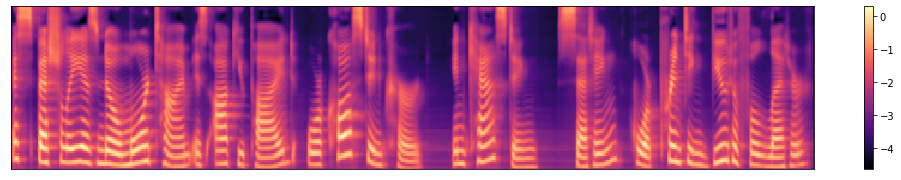

In [11]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 11:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [12]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(171520,)


0.014089584350585938


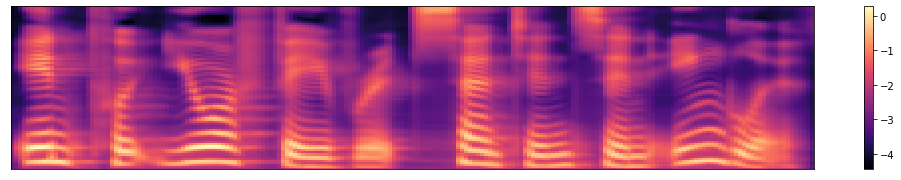

(51712,)


In [18]:
from g2p_en import G2p

g2p = G2p()

t0 = time.time()
text = "Input your favorite sentence in English"
text_array = g2p(text)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():
    
    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    t1 = time.time()
    print(t1 - t0)
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)